# Keras: Image Forecasting

*Lunar Astronomy Forecasting Using a 5D Time Series of Shifting Windows.*

![liberty](../images/liberty_moon_banner.png)

Although the pipeline runs successfully, this tutorial is considered a 'work in progress' in that the model architecture still needs a bit of work. Here we attempt an self-supervised *walk forward* with an autoencoder whose evaluation data is shifted 2 frames forward. The goal is to show an image to the model and have it infer what that image will look like 2 steps in the future.

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, UpSampling1D
from keras.callbacks import History

from sklearn.preprocessing import FunctionTransformer

import aiqc

---

## Low-Level API

Reference [Low-Level API Docs](api_low_level.ipynb) for more information including how to work with non-tabular data and defining optimizers.

In [3]:
folder_path = 'remote_datum/image/liberty_moon/images'
image_dataset = aiqc.Dataset.Image.from_folder_pillow(folder_path=folder_path, ingest=False, dtype='float64')

🖼️ Ingesting Images 🖼️: 100%|███████████████████████| 15/15 [00:00<00:00, 122.39it/s]


In [4]:
feature = image_dataset.make_feature()

In [5]:
feature.make_window(size_window=1, size_shift=2)

<Window: 13>

In [6]:
encoderset = feature.make_encoderset()
encoderset.make_featurecoder(
    sklearn_preprocess= FunctionTransformer(aiqc.div255, inverse_func=aiqc.mult255)
    , dtypes = 'float64'
)


___/ featurecoder_index: 0 \_________

=> The column(s) below matched your filter(s) featurecoder filters.

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']

=> Done. All feature column(s) have featurecoder(s) associated with them.
No more Featurecoders can be added to this Encoderset.



<Featurecoder: 41>

In [7]:
feature.make_featureshaper(reshape_indices=(0,3,4))

<Featureshaper: 3>

In [8]:
splitset = aiqc.Splitset.make(
    feature_ids = feature.id
    , size_test = 0.1
    , size_validation = 0.20
)

In [9]:
splitset.samples

{'train': [0, 2, 3, 6], 'validation': [4, 5], 'test': [1]}

In [10]:
def fn_build(features_shape, label_shape, **hp):
    m = Sequential()
    m.add(Conv1D(64*hp['multiplier'], 3, activation=hp['activation'], padding='same'))
    m.add(MaxPool1D( 2, padding='same'))
    m.add(Conv1D(32*hp['multiplier'], 3, activation=hp['activation'], padding='same'))
    m.add(MaxPool1D( 2, padding='same'))
    m.add(Conv1D(16*hp['multiplier'], 3, activation=hp['activation'], padding='same'))
    m.add(MaxPool1D( 2, padding='same'))

    # decoding architecture
    m.add(Conv1D(16*hp['multiplier'], 3, activation=hp['activation'], padding='same'))
    m.add(UpSampling1D(2))
    m.add(Conv1D(32*hp['multiplier'], 3, activation=hp['activation'], padding='same'))
    m.add(UpSampling1D(2))
    m.add(Conv1D(64*hp['multiplier'], 3, activation=hp['activation']))
    m.add(UpSampling1D(2))
    m.add(Conv1D(50, 3, activation='relu', padding='same'))# removing sigmoid
    return m

In [18]:
def fn_train(model, loser, optimizer, samples_train, samples_evaluate, **hp):
    model.compile(
        optimizer=optimizer
        , loss=loser
        , metrics=['mean_squared_error']
    )

    model.fit(
        samples_train["features"]
        , samples_train["labels"]
        , validation_data = (
            samples_evaluate["features"]
            , samples_evaluate["labels"]
        )
        , verbose = 0
        , batch_size = hp['batch_size']
        , callbacks=[keras.callbacks.History()]
        , epochs = hp['epoch_count']
    )
    return model

In [19]:
algorithm = aiqc.Algorithm.make(
    library = "keras"
    , analysis_type = "regression"
    , fn_build = fn_build
    , fn_train = fn_train
)

In [20]:
hyperparameters = dict(
    epoch_count = [150]
    , batch_size = [1]
    , cnn_init = ['he_normal']
    , activation = ['relu']
    , multiplier = [3]
)

In [21]:
hyperparamset = algorithm.make_hyperparamset(
    hyperparameters = hyperparameters
)

In [22]:
queue = algorithm.make_queue(
    splitset_id = splitset.id
    , hyperparamset_id = hyperparamset.id
    , repeat_count = 1
)

In [23]:
queue.run_jobs()

🔮 Training Models 🔮: 100%|██████████████████████████████████████████| 1/1 [00:12<00:00, 12.31s/it]


For more information on visualization of performance metrics, reference the [Visualization & Metrics](visualization.html) documentation.

---

## Inference

In [24]:
queue.metrics_to_pandas()

,hyperparamcombo_id,job_id,predictor_id,split,explained_variance,loss,mse,r2
0,104,112,137,train,0.675259,1.063257,41.360072,0.671978
1,104,112,137,validation,0.733589,1.749223,53.674014,0.703043
2,104,112,137,test,0.768045,1.714646,51.290583,0.712528


In [25]:
# queue.plot_performance(max_loss=10000, min_r2=-1000)

In [46]:
predictor = aiqc.Predictor.get_by_id(137) #replace with your `Predictor.id`

In [47]:
predictor.get_hyperparameters(as_pandas=True)

,param,value
0,epoch_count,150
1,batch_size,1
2,cnn_init,he_normal
3,activation,relu
4,multiplier,3


In [48]:
# predictor.plot_learning_curve(loss_skip_15pct=True)

In [49]:
import numpy as np

In [52]:
prediction = np.array(predictor.predictions[0].predictions['test'][0].astype('uint8'))

In [53]:
prediction

array([[124,  97, 214, ...,  33, 119, 189],
       [ 59, 129, 221, ...,  25, 164, 234],
       [237, 116, 172, ..., 220, 140, 178],
       ...,
       [154, 250,  99, ...,  10, 246, 246],
       [158, 234,  61, ..., 177,  67, 102],
       [ 86,  13, 249, ..., 233, 197,  70]], dtype=uint8)

In [54]:
prediction.shape

(60, 50)

In [55]:
from PIL import Image as Imaje

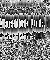

In [56]:
Imaje.fromarray(prediction, mode='L')